
Часть 2. Preprocessing & Feature Engineering

    Ваша цель получить как можно более высокие метрики качества (можно взять несколько, R2, MAE, RMSE), сконцентрировавшись на преобразовании признаков.

    Опробуйте различные техники:
    работа с категориальными переменными (можно начать с dummy);
    замена аномалий;
    различные варианты шкалирования непрерывных переменных (StandardScaler, RobustScaler, и.т.д.);

    обратите внимание на распределение целевой переменной, возможно, с ней тоже можно поработать;

    Попробуйте на основании имеющихся переменных создать новые, которые могли бы улучшить качество модели.
    Например, можно найти координаты Манхэттена (самого дорогого района) и при помощи широты и долготы,
    а также евклидового расстояния создать новую переменную - расстояние от квартиры до этого района.
    Возможно, такой признак будет работать лучше, чем просто широта и долгота.

Часть 3. Моделирование

    Отложите 30% данных для тестирования.
    Постройте модели простой линейной регрессии, RidgeCV, LassoCV и ElasticNetCV.
    Измерьте качество каждой и визуализируйте важность признаков.
    Сделайте интересные выводы :)

    В ноутбуке желательно видеть:

    Понятное описание: какие техники и алгоритмы были опробованы - было бы неплохо в самом начале тезисно выписать опробованные методики и их результат (помогло / не помогло).
    Наличие визуализаций (не обязательно строить много графиков - можно несколько репрезентативных).
    Наличие хотя бы одной модификации данных, приводящей к улучшению результатов.



Что помогло/не помогло
- Помогла замена NaN на цифровое значение 0
- Помогло кодирование категориального признака room_type с помощью one-hot encoding
- по результатам корреляций оказалось возможно отбросить колонку с категориальным признаком состоящим из более чем 200 значений
- Не помогла нормализация - с ней оценки моделей хуже, видимо - это особенность распределения цены
- добавление переменной расстояния до центра не поможет в оценке датасета, т.к. корреляция очень мала.
- CatBoost показал результаты лучше, чем другие модели, но ориентировался на те же признаки.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import LinearRegression

# % matplotlib inline
import warnings

warnings.filterwarnings("ignore")

In [4]:
raw_data = pd.read_csv('AB_NYC_2019.csv', sep=',')

Часть 1. EDA

Скачайте данные с Kaggle по ценам на жильё в Airbnb в Нью-Йорке:
https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data
Пройдите по основным шагам работы с данными - базовые статистики, визуализации (распределения, корреляции, pair plots), предобработка переменных.
Переменные, которые пока нужно убрать: id, name, host_id, host_name, last_review.


# Base EDA

In [5]:
raw_data.head(20)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129
6,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,2017-10-05,0.40,1,0
7,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,3.47,1,220
8,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,118,2017-07-21,0.99,1,0
9,5238,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,1,160,2019-06-09,1.33,4,188


Выкинем заведомо ненужные колонки.

In [6]:
data = raw_data.drop(['id', 'name', 'host_id', 'host_name', 'last_review'], axis=1)

Посмотрим, сколько имеется NaN:

In [11]:
data.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [12]:
data.reviews_per_month.fillna(0,
                              inplace=True)  #т.к. эта колонка отображает количественно сколько обзоров было сделано, то логично заменить NaN на 0, так и делаем.

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   neighbourhood                   48895 non-null  object 
 2   latitude                        48895 non-null  float64
 3   longitude                       48895 non-null  float64
 4   room_type                       48895 non-null  object 
 5   price                           48895 non-null  int64  
 6   minimum_nights                  48895 non-null  int64  
 7   number_of_reviews               48895 non-null  int64  
 8   reviews_per_month               48895 non-null  float64
 9   calculated_host_listings_count  48895 non-null  int64  
 10  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 4.1+ MB


In [16]:
data.isnull().sum() #''' NaN больше не осталось, качество датасета улучшилось. '''

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

Посмотрим, что собой представляют категориальные переменные

In [17]:
data[['neighbourhood_group', 'neighbourhood', 'room_type']].nunique()

neighbourhood_group      5
neighbourhood          221
room_type                3
dtype: int64

In [18]:
data.neighbourhood.value_counts().head(15)

Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
Hell's Kitchen        1958
East Village          1853
Upper East Side       1798
Crown Heights         1564
Midtown               1545
East Harlem           1117
Greenpoint            1115
Chelsea               1113
Lower East Side        911
Astoria                900
Name: neighbourhood, dtype: int64

In [19]:
import phik

In [20]:
# Обычная корреляционная матрица не информативна, попробуем воспользоваться альтернативной. категориальные переменные по прежнему не преобразованы.
phik_overview = data.phik_matrix()

interval columns not set, guessing: ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']


In [21]:
phik_overview['price'].sort_values(ascending=False)

price                             1.000000
availability_365                  0.057034
neighbourhood                     0.048470
neighbourhood_group               0.044008
minimum_nights                    0.043947
room_type                         0.041901
longitude                         0.039992
latitude                          0.026334
number_of_reviews                 0.000000
reviews_per_month                 0.000000
calculated_host_listings_count    0.000000
Name: price, dtype: float64

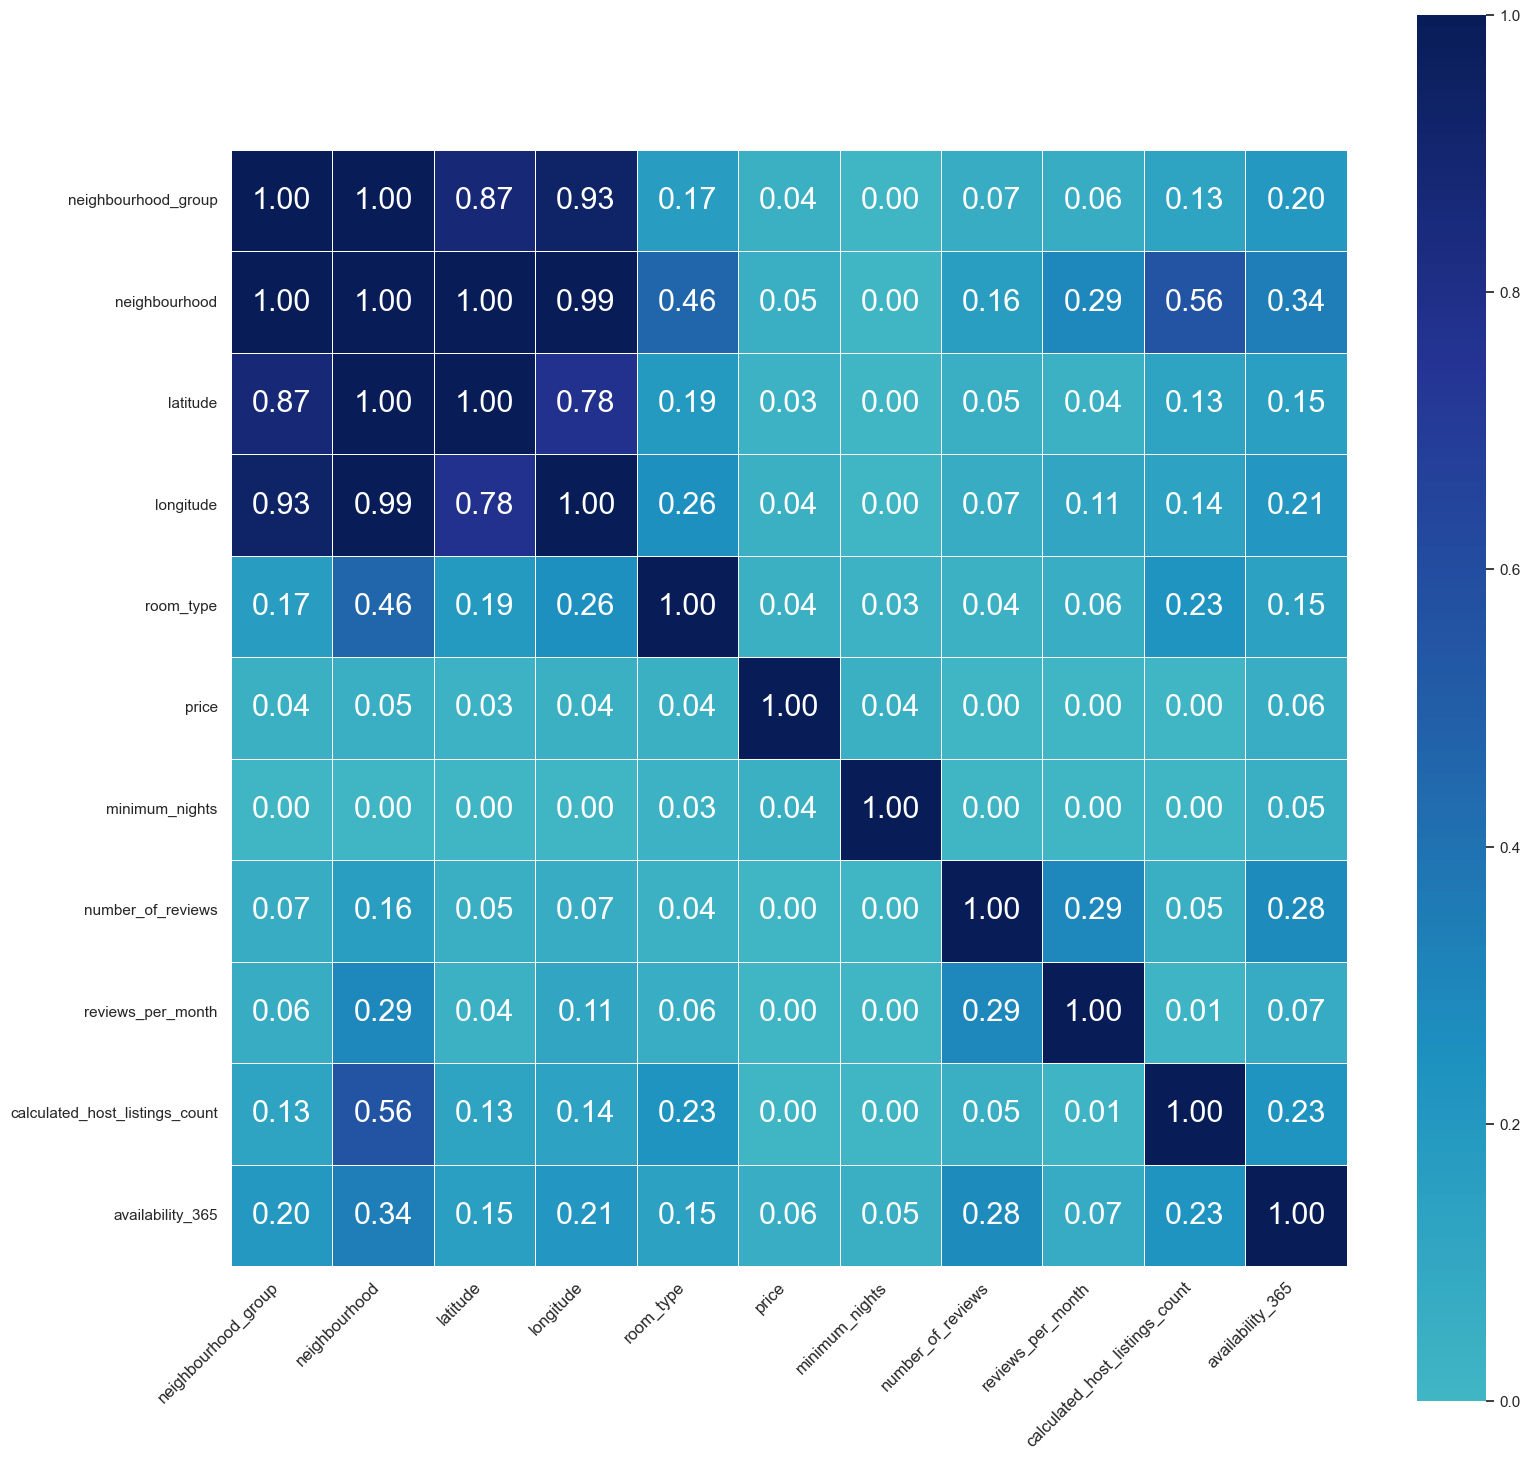

In [24]:
sns.set(rc={'figure.figsize': (18, 18)})
ax = sns.heatmap(phik_overview, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 22},
                 vmin=0, center=0,
                 cmap="YlGnBu", linewidths=.5)
plt.xticks(rotation=45, ha='right', fontsize=12)
# plt.yticks(rotation=45, ha='right', fontsize=12)
plt.show()

заметного улучшения не наблюдается, зависимостей с ценой не наблюдается, т.к. все зависимые признаки категориальные.
перед преобразованием проанализируем информацию, которой располагаем.
Посмотрим распределение цен относительно кварталов.

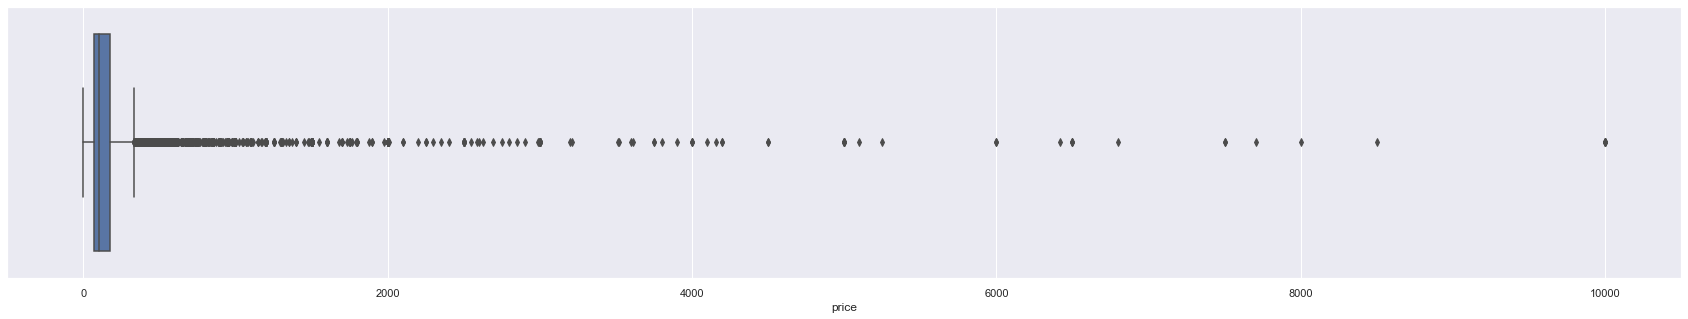

In [422]:
plt.figure(figsize=(30, 5))
sns.boxplot(data.price)
plt.show()
# наблюдаются сильные выбросы цен, которые будут мешать анализу

<AxesSubplot:xlabel='price', ylabel='Count'>

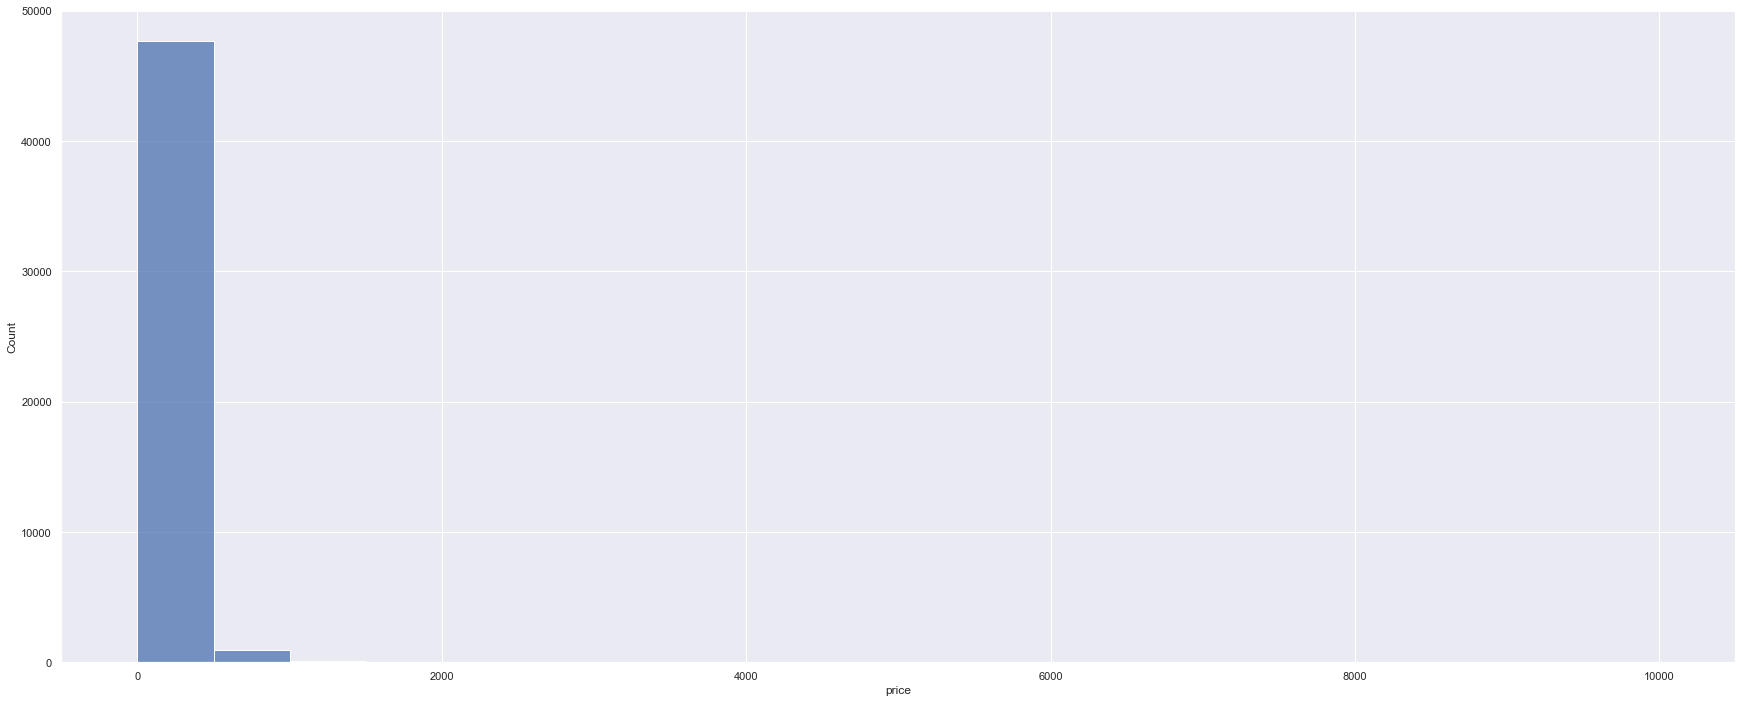

In [423]:
plt.figure(figsize=(30, 12))
sns.histplot(data['price'], bins=20)
# На гистограмме выбросы видно значительно хуже.

In [424]:
# попробуем создать копию оригинального датасета с выборкой по цене от 10 до 2000
# part_data = data.query('price <= 1001 & price >= 10')
# part_data.shape  # как видно, потеря составила меньше 100 строк, что меньше четверти процента. при верхнем пороге в 1000 - потеря 250 строк ровно, что чуть больше полупроцента.

In [425]:
# part_data.price.describe()

(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.]),
 [Text(0, -2000.0, '−2000'),
  Text(0, 0.0, '0'),
  Text(0, 2000.0, '2000'),
  Text(0, 4000.0, '4000'),
  Text(0, 6000.0, '6000'),
  Text(0, 8000.0, '8000'),
  Text(0, 10000.0, '10000'),
  Text(0, 12000.0, '12000')])

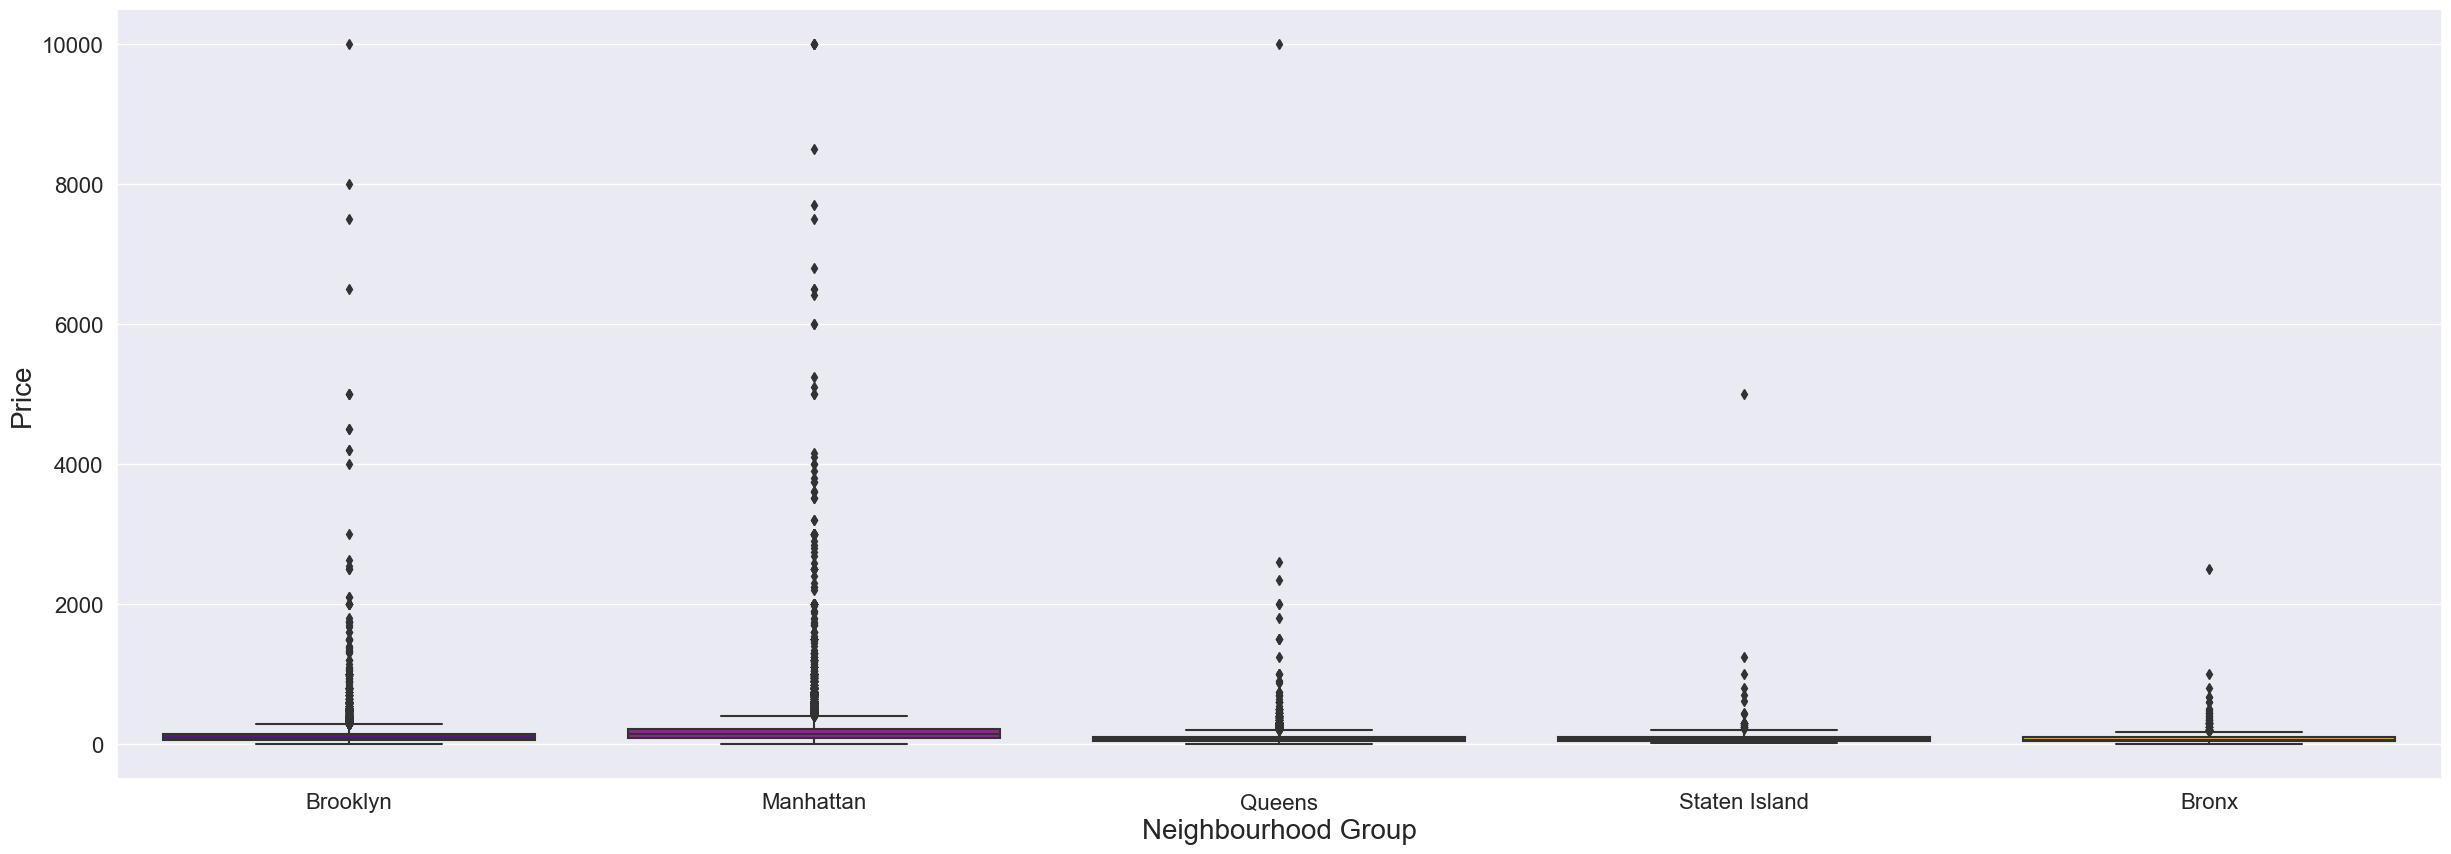

In [28]:
plt.figure(figsize=(30, 10))
sns.boxplot(data=data, x='neighbourhood_group', y='price', palette='plasma')
plt.xlabel('Neighbourhood Group', fontsize=20)
plt.xticks(fontsize=16)
plt.ylabel('Price', fontsize=20)
plt.yticks(fontsize=16)

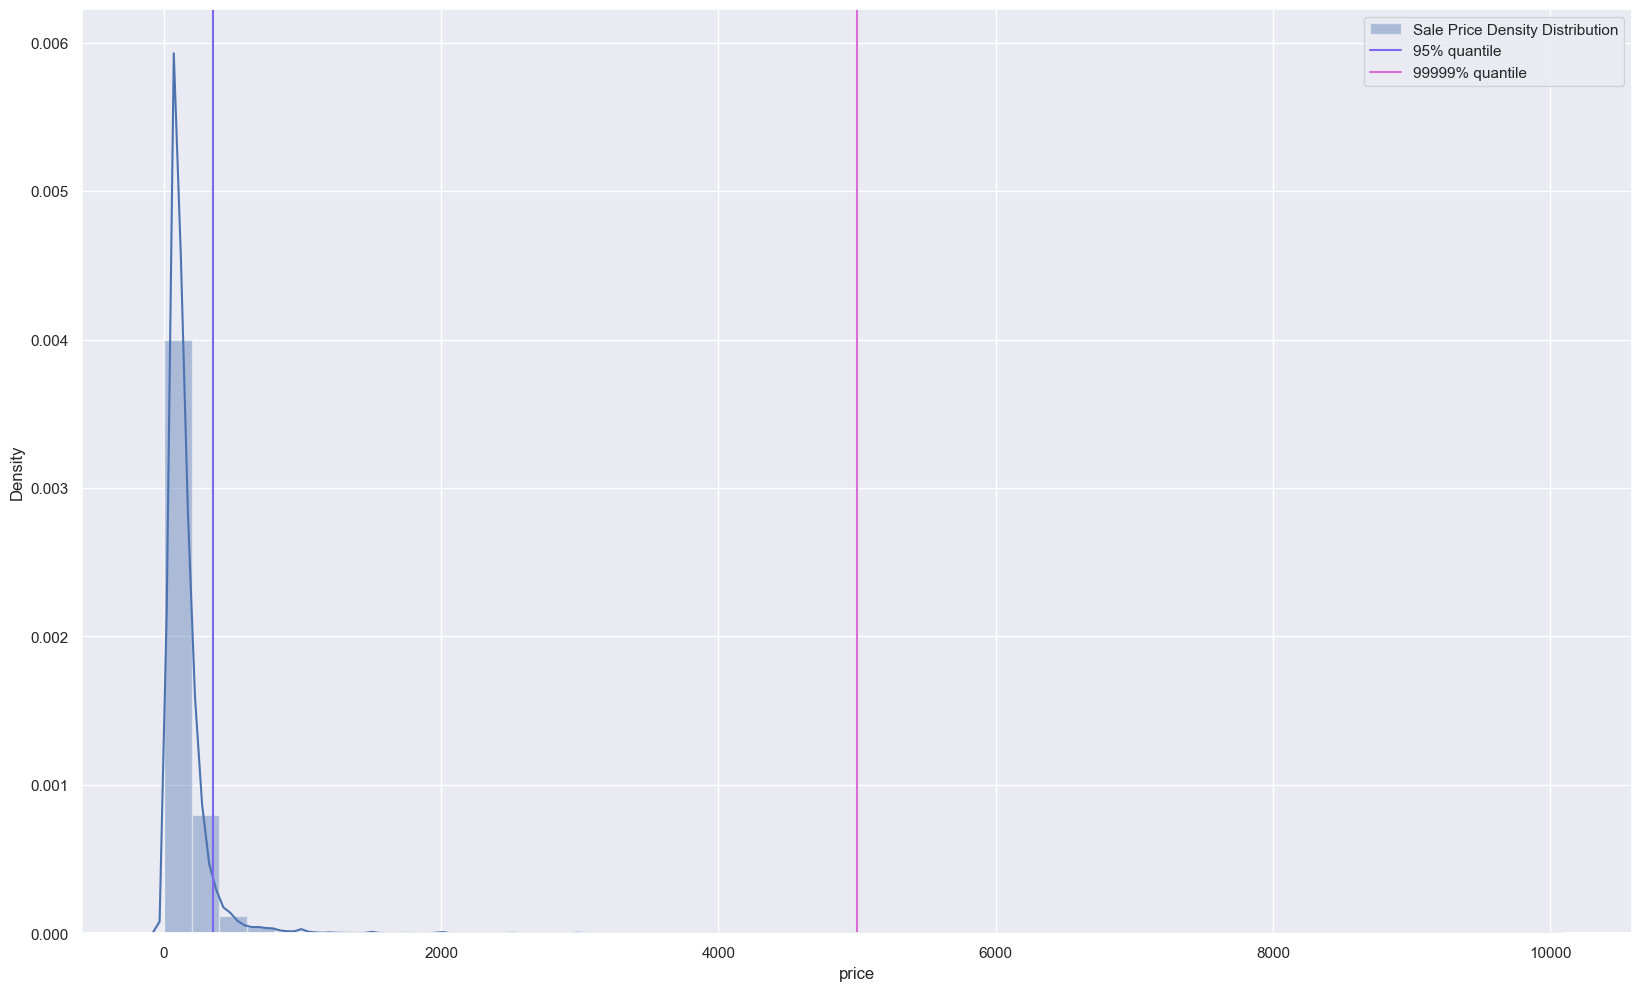

In [29]:
plt.subplots(figsize=(20, 12))
sns.distplot(data['price'], label='Sale Price Density Distribution')
plt.axvline(data.price.quantile(0.95), label='95% quantile', c='mediumslateblue')
plt.axvline(data.price.quantile(0.9995), label='99999% quantile', c='orchid')
plt.legend()
plt.show()

Часть 2. Preprocessing & Feature Engineering

In [435]:
data=data.loc[data.price<8000]
data.shape

(48887, 11)

# Распределение целевой переменной

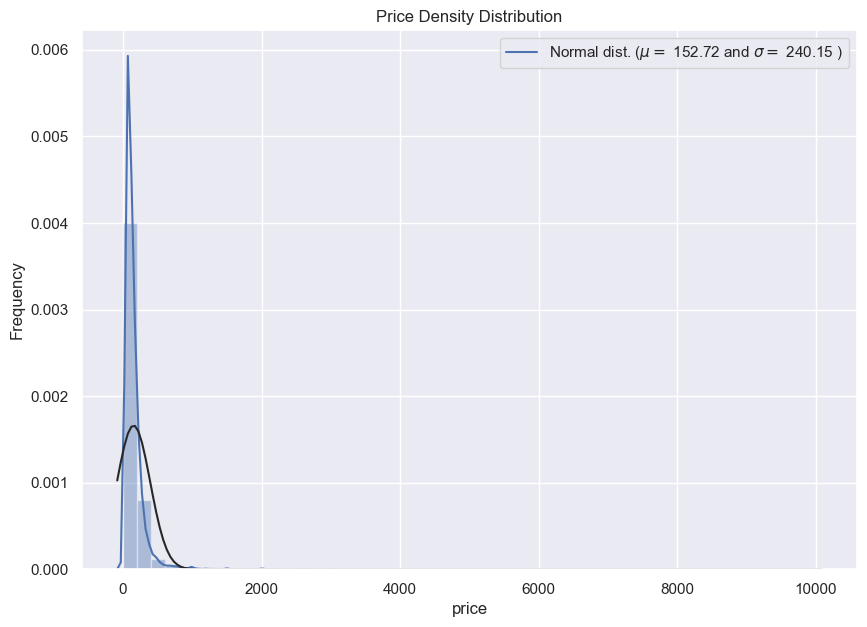

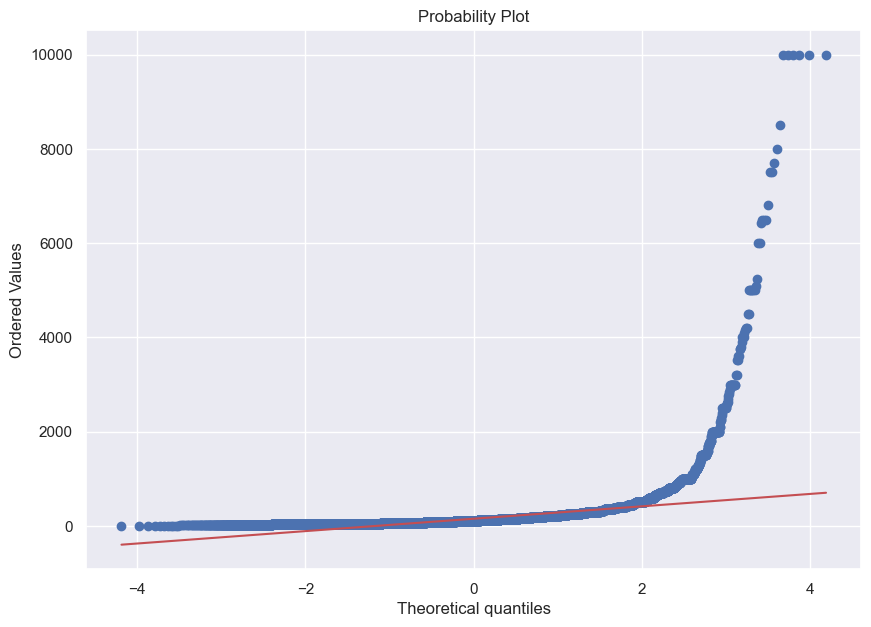

In [31]:
from scipy import stats
from scipy.stats import norm

plt.figure(figsize=(10, 7))
sns.distplot(data.price, fit=norm)

# фитим распределение
(mu, sigma) = norm.fit(data.price)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Price Density Distribution')

plt.figure(figsize=(10, 7))
stats.probplot(data['price'], plot=plt)
plt.show()

# Зададим функцию, которая кодирует категориальные признаки выбранным методом.

In [44]:
data

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...
48890,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,0.00,2,9
48891,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,0.00,2,36
48892,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,0.00,1,27
48893,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,0.00,6,2


In [43]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

enc = OneHotEncoder()
encoded_data = enc.fit_transform(data[['neighbourhood_group', 'room_type']])
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=enc.get_feature_names_out(['neighbourhood_group', 'room_type']))

data_enc = data.drop(['neighbourhood_group', 'room_type', 'neighbourhood'], axis=1).join(encoded_df)
data_enc.head()


,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,40.64749,-73.97237,149,1,9,0.21,6,365,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,40.75362,-73.98377,225,1,45,0.38,2,355,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,40.80902,-73.94190,150,3,0,0.00,1,365,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,40.68514,-73.95976,89,1,270,4.64,1,194,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,40.79851,-73.94399,80,10,9,0.10,1,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


# берем логарифм от цены ot data_enc

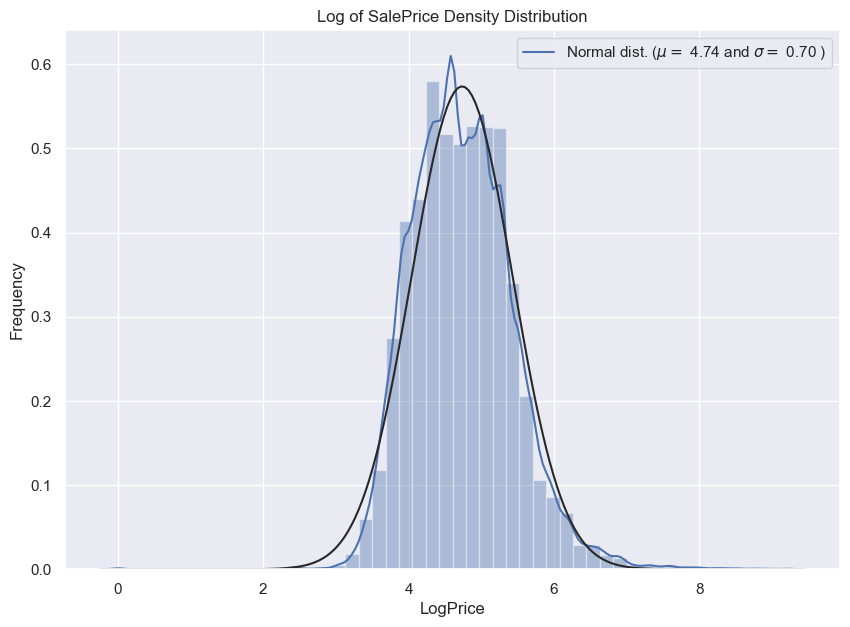

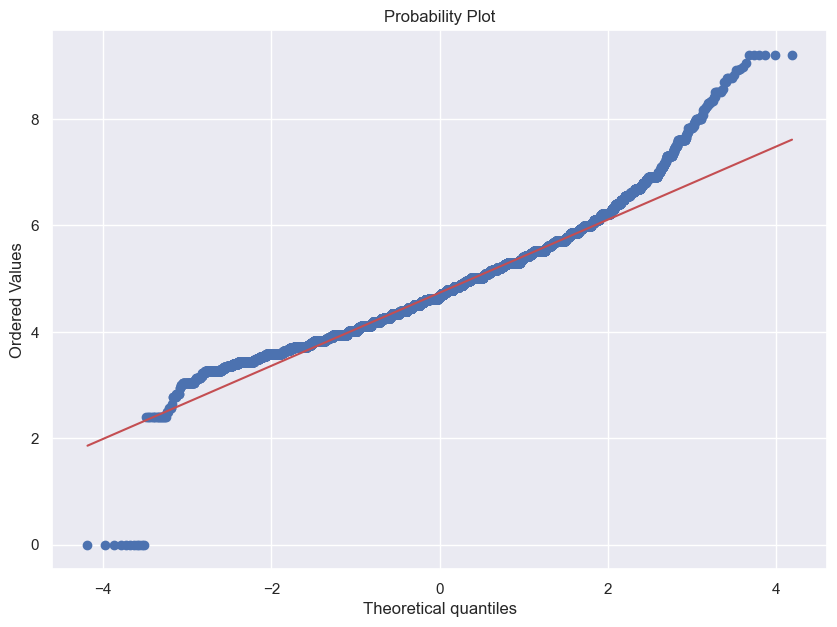

In [45]:
log_data = data_enc.copy()
log_data['LogPrice'] = np.log1p(data_enc.price)

log_data.drop(['price'], axis=1, inplace=True)

plt.figure(figsize=(10, 7))
sns.distplot(log_data.LogPrice, fit=norm)

# фитим распределение на логарифм от цены
(mu, sigma) = norm.fit(log_data.LogPrice)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Log of SalePrice Density Distribution')

plt.figure(figsize=(10, 7))
stats.probplot(log_data.LogPrice, plot=plt)
plt.show()

# Строим матрицу кореляции в датафрейме с логарифмированной ценой

interval columns not set, guessing: ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island', 'room_type_Entire home/apt', 'room_type_Private room', 'room_type_Shared room', 'LogPrice']


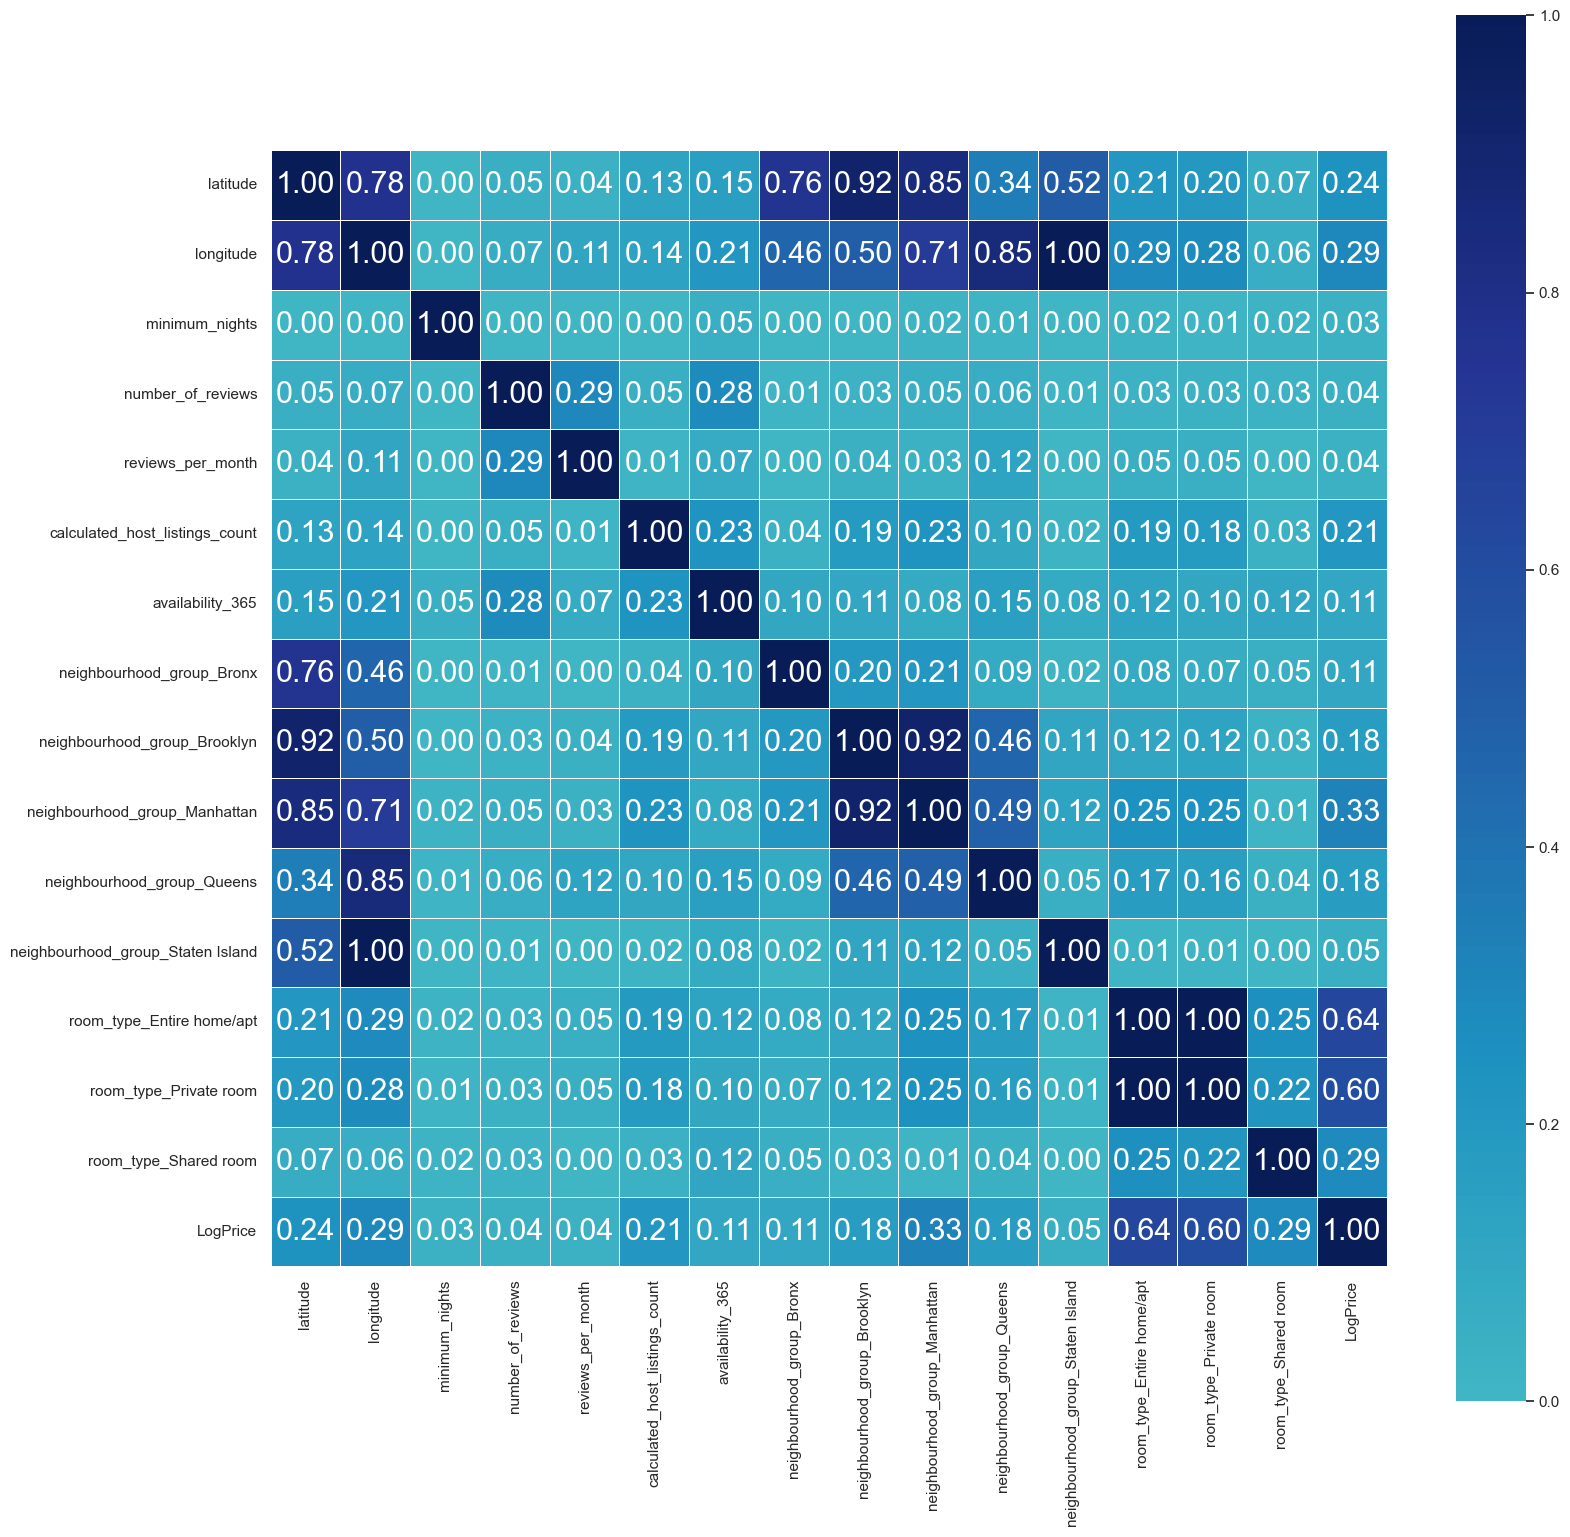

In [46]:
phik_overview = log_data.phik_matrix()
sns.set(rc={'figure.figsize': (18, 18)})
ax = sns.heatmap(phik_overview, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 22},
                 vmin=0, center=0,
                 cmap="YlGnBu", linewidths=.5)
plt.show()

# Отберём 8 самых скоррелированных признаков

In [47]:
cols = phik_overview.nlargest(8, 'LogPrice')['LogPrice'].index.tolist()
cols

['LogPrice',
 'room_type_Entire home/apt',
 'room_type_Private room',
 'neighbourhood_group_Manhattan',
 'longitude',
 'room_type_Shared room',
 'latitude',
 'calculated_host_listings_count']

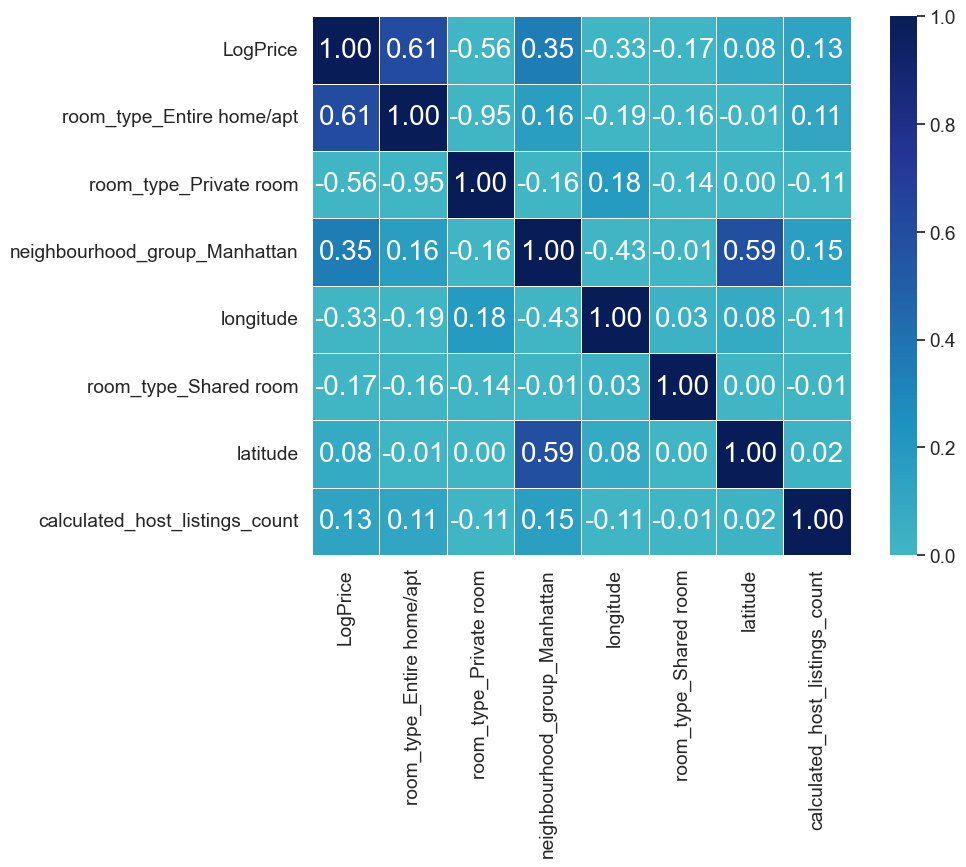

In [49]:
cm = np.corrcoef(log_data[cols].values.T)
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.25)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 20},
            yticklabels=cols, xticklabels=cols, vmin=0, center=0, cmap="YlGnBu", linewidths=.5)
plt.show()

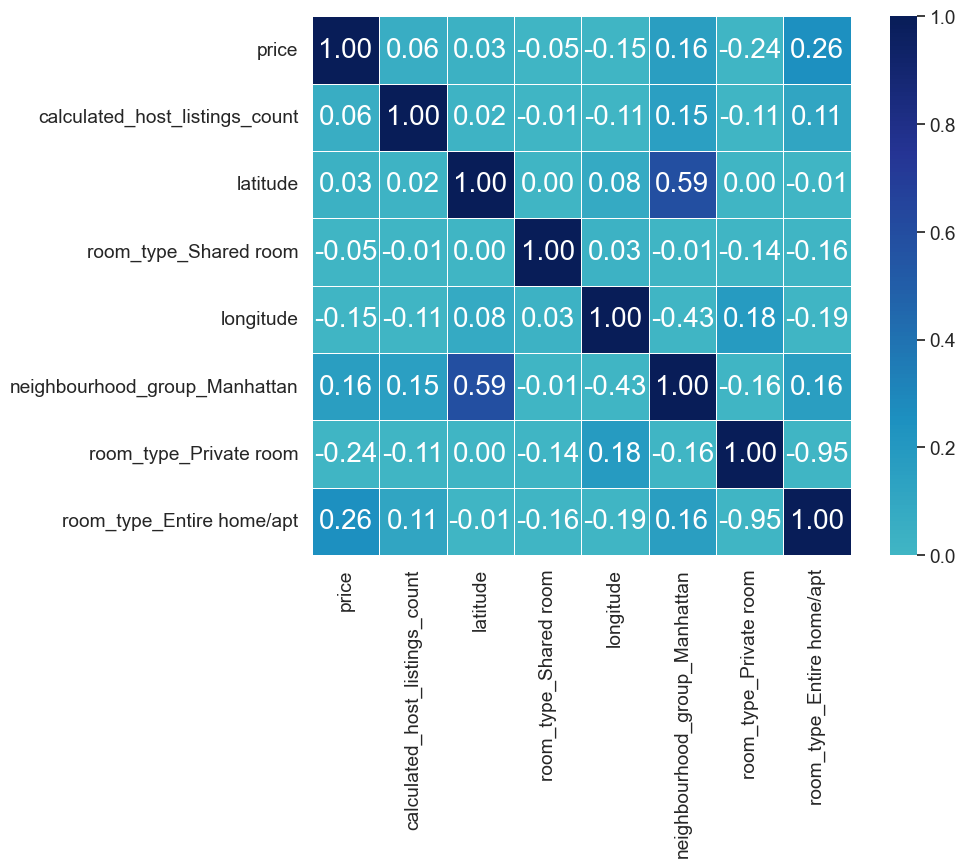

In [50]:
cols = cols[1:]
cols.append('price')
cols = cols[::-1]
cm = np.corrcoef(data_enc[cols].values.T)
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.25)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 20},
            yticklabels=cols, xticklabels=cols, vmin=0, center=0, cmap="YlGnBu", linewidths=.5)
plt.show()


In [51]:
# Приготовим набор для тренировки и тестирования
X = log_data.drop('LogPrice', axis=1)
Y = log_data['LogPrice']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

In [52]:
from sklearn.tree import DecisionTreeRegressor
clf = DecisionTreeRegressor(max_depth=5, random_state=42)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

model = clf
results = {}
result = {}
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
result["Test MSE"] = mean_squared_error(y_test, y_pred)
result["Train MSE"] = mean_squared_error(y_train, y_train_pred)
result["Test MAE"] = mean_absolute_error(y_test, y_pred)
result["Train MAE"] = mean_absolute_error(y_train, y_train_pred)
result["Test r2_score"] = r2_score(y_test, y_pred)
result["Train r2_score"] = r2_score(y_train, y_train_pred)
results[type(model).__name__] = result
pd.DataFrame(results)

,DecisionTreeRegressor
Test MAE,0.342370
Test MSE,0.223111
Test r2_score,0.527935
Train MAE,0.343587
Train MSE,0.231955
Train r2_score,0.524818


In [53]:
model = DecisionTreeRegressor
feature_importances = zip(X_train.columns, clf.feature_importances_)
list(feature_importances)

[('latitude', 0.07243462705900017),
 ('longitude', 0.08460133115087544),
 ('minimum_nights', 0.010392192486464367),
 ('number_of_reviews', 0.00602241314481795),
 ('reviews_per_month', 0.0),
 ('calculated_host_listings_count', 0.002137096547086747),
 ('availability_365', 0.03240479234133861),
 ('neighbourhood_group_Bronx', 0.0),
 ('neighbourhood_group_Brooklyn', 0.0),
 ('neighbourhood_group_Manhattan', 0.06204503772116121),
 ('neighbourhood_group_Queens', 0.0),
 ('neighbourhood_group_Staten Island', 0.0),
 ('room_type_Entire home/apt', 0.7134970983024214),
 ('room_type_Private room', 0.014300027499666334),
 ('room_type_Shared room', 0.0021653837471675556)]

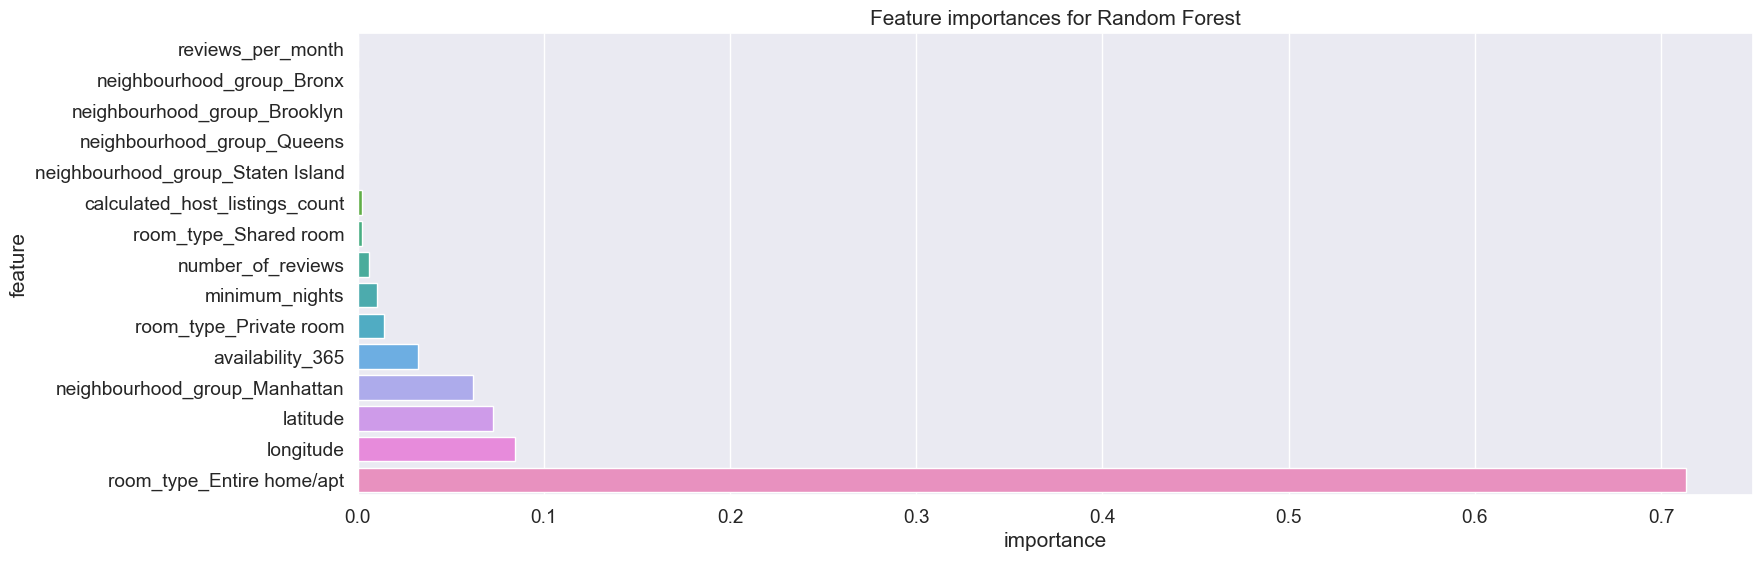

In [56]:
feature_importances = zip(X_train.columns, clf.feature_importances_)
feature_importances = sorted(feature_importances, key=lambda x: x[1])
feature_importances = pd.DataFrame(feature_importances, columns=['feature', 'importance'])

plt.figure(figsize=(18, 6))
plt.title('Feature importances for Random Forest')
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.show()

Построив дерево решений и посмотрев характеристику feature_importances мы выяснили, что большее влияние имеет room_type_Entire home/apt
далее попробуем это подтвердить или опровергнуть

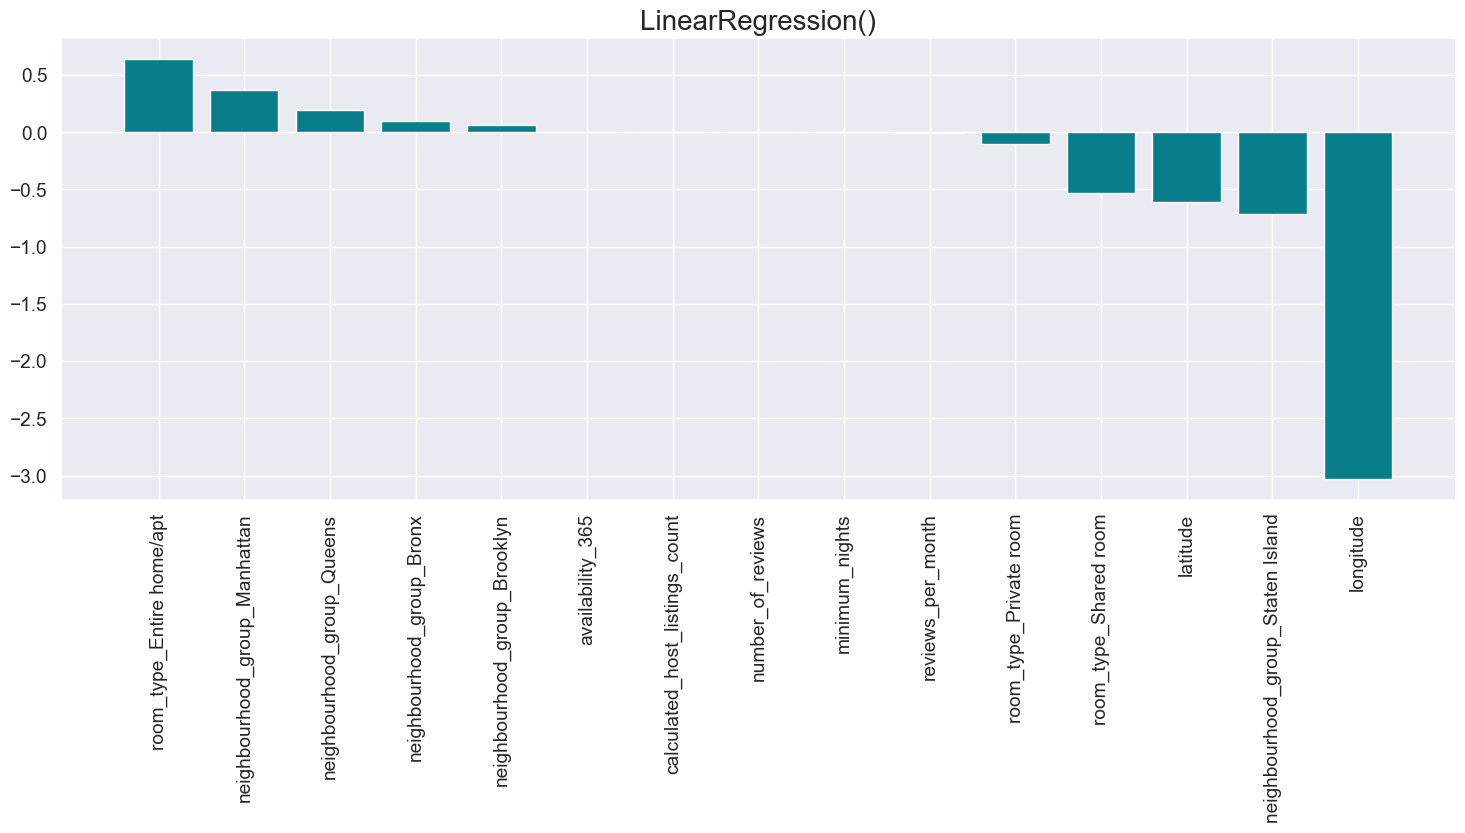

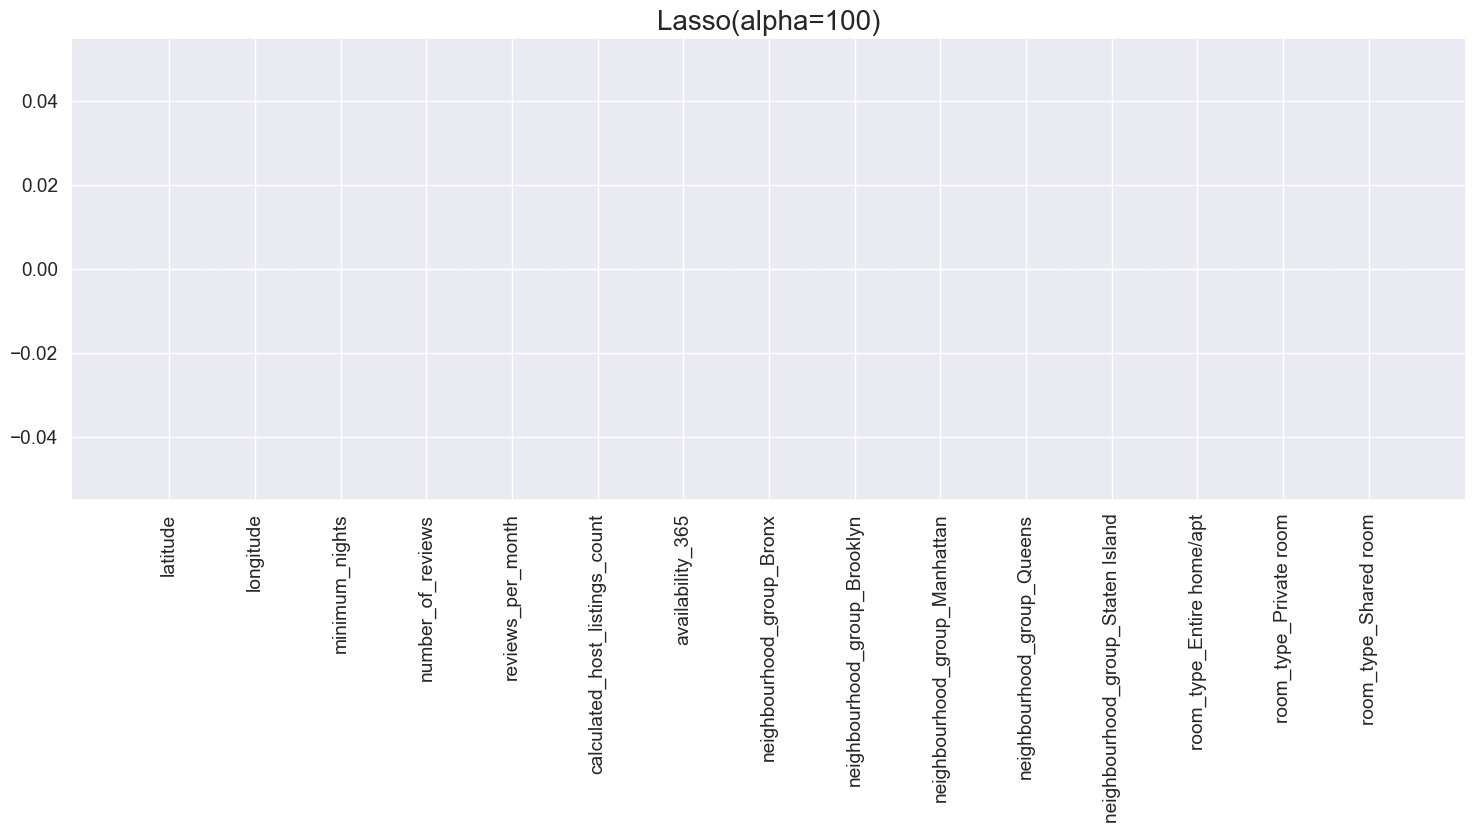

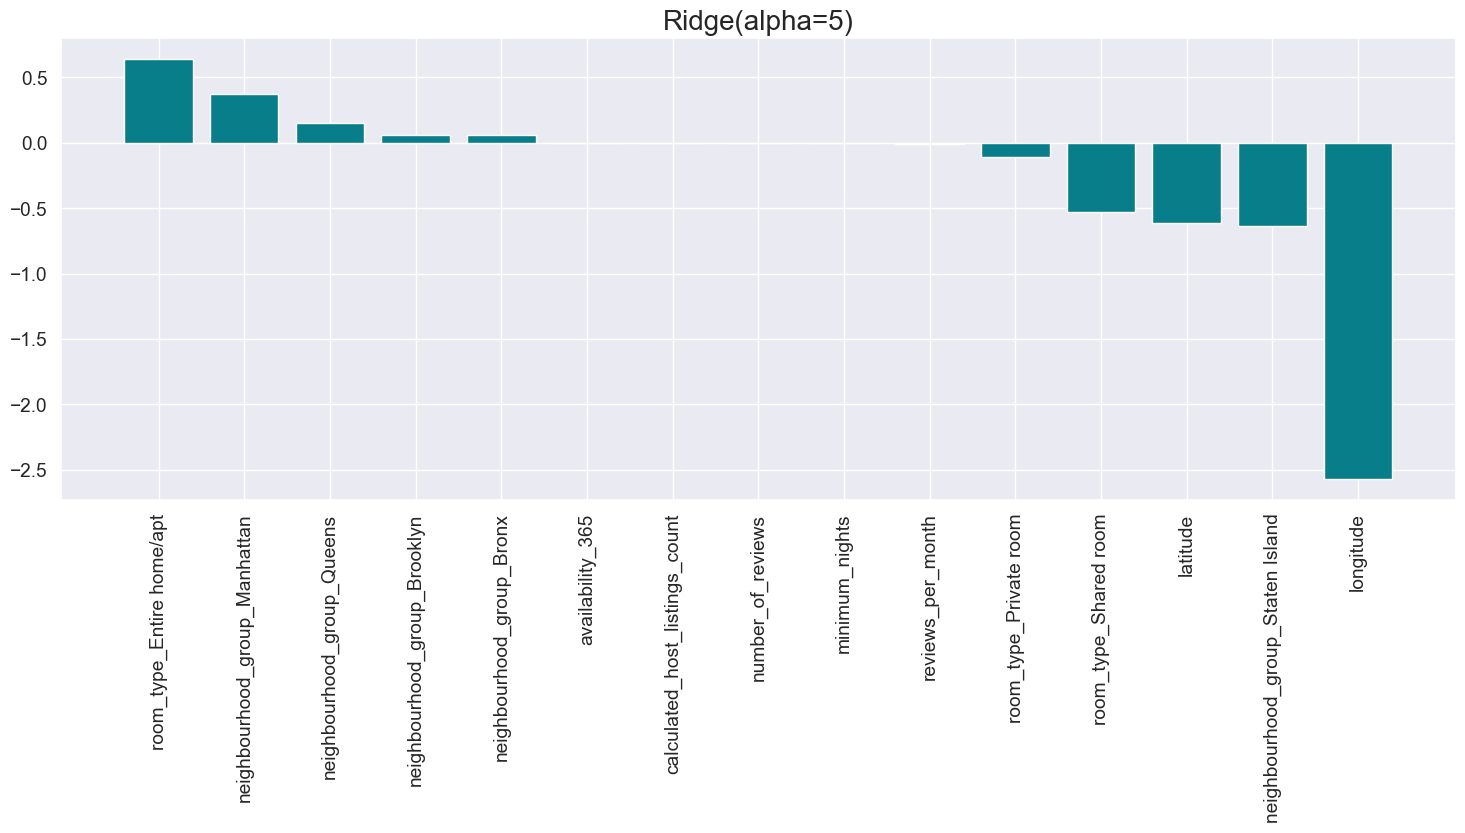

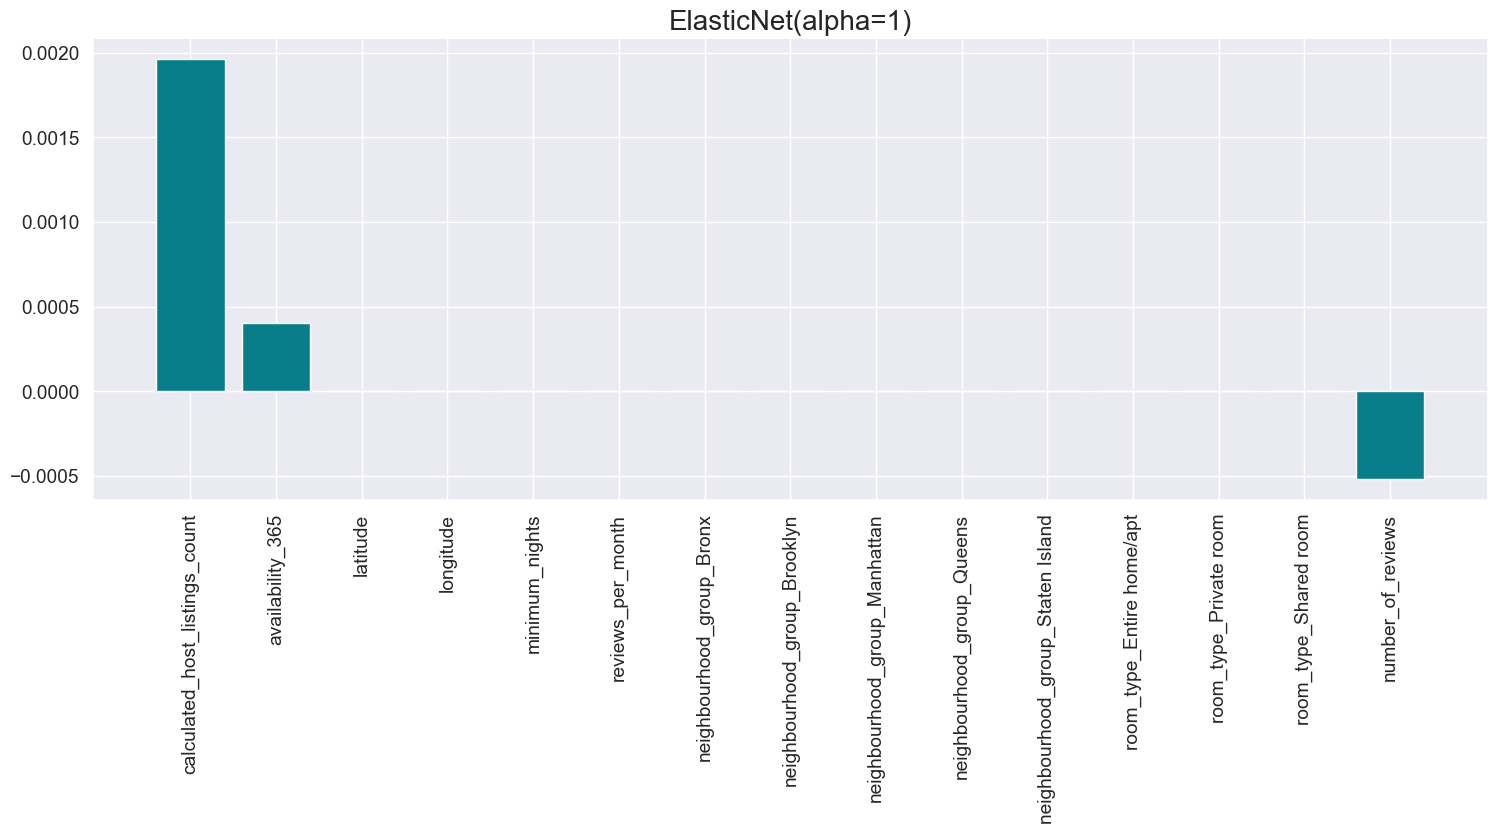

,LinearRegression,Lasso,Ridge,ElasticNet
Test MSE,0.238176,0.472669,0.238281,0.461279
Train MSE,0.251482,0.488139,0.251663,0.476348
Test MAE,0.356742,0.546079,0.356768,0.536500
Train MAE,0.361308,0.550710,0.361445,0.541570
Test r2_score,0.496060,-0.000089,0.495836,0.024011
Train r2_score,0.484815,0.000000,0.484444,0.024154


In [57]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

# Построим модели и оценим их качество на ненормализованных данных

results = {}
for model in LinearRegression(), Lasso(alpha=100), Ridge(alpha=5), ElasticNet(alpha=1):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    result = {}
    result["Test MSE"] = mean_squared_error(y_test, y_pred)
    result["Train MSE"] = mean_squared_error(y_train, y_train_pred)
    result["Test MAE"] = mean_absolute_error(y_test, y_pred)
    result["Train MAE"] = mean_absolute_error(y_train, y_train_pred)
    result["Test r2_score"] = r2_score(y_test, y_pred)
    result["Train r2_score"] = r2_score(y_train, y_train_pred)
    results[type(model).__name__] = result

    importances = pd.DataFrame(data={'Attribute': X_train.columns, 'Importance': model.coef_})
    importances = importances.sort_values(by='Importance', ascending=False)
    importances[:10]

    plt.figure(figsize=(18, 6))
    plt.bar(x=importances[:20]['Attribute'], height=importances[:20]['Importance'], color='#087E8B')
    plt.title(model, size=20)
    plt.xticks(rotation='vertical')
    plt.show()

pd.DataFrame(results)

линейная регрессия показывает лучшие результаты и так же выявляет room_type_Entire home/apt как важную составляющую цены.


In [58]:
from sklearn.preprocessing import StandardScaler, RobustScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [59]:
results = {}
for model in LinearRegression(), Lasso(alpha=100), Ridge(alpha=100), ElasticNet(alpha=1):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    result = {}
    result["Test MSE"] = mean_squared_error(y_test, y_pred)
    result["Train MSE"] = mean_squared_error(y_train, y_train_pred)
    result["Test MAE"] = mean_absolute_error(y_test, y_pred)
    result["Train MAE"] = mean_absolute_error(y_train, y_train_pred)
    result["Test r2_score"] = r2_score(y_test, y_pred)
    result["Train r2_score"] = r2_score(y_train, y_train_pred)
    results[type(model).__name__] = result
pd.DataFrame(results, index=['Test MSE', 'Train MSE', 'Test MAE', 'Train MAE', 'Test r2_score', 'Train r2_score'])

,LinearRegression,Lasso,Ridge,ElasticNet
Test MSE,0.238176,0.472669,0.238177,0.472669
Train MSE,0.251482,0.488139,0.251483,0.488139
Test MAE,0.356742,0.546079,0.356717,0.546079
Train MAE,0.361308,0.550710,0.361281,0.550710
Test r2_score,0.496060,-0.000089,0.496058,-0.000089
Train r2_score,0.484815,0.000000,0.484813,0.000000


In [60]:
scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
results = {}
for model in LinearRegression(), Lasso(alpha=100), Ridge(alpha=100), ElasticNet(alpha=1):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    result = {}
    result["Test MSE"] = mean_squared_error(y_test, y_pred)
    result["Train MSE"] = mean_squared_error(y_train, y_train_pred)
    result["Test MAE"] = mean_absolute_error(y_test, y_pred)
    result["Train MAE"] = mean_absolute_error(y_train, y_train_pred)
    result["Test r2_score"] = r2_score(y_test, y_pred)
    result["Train r2_score"] = r2_score(y_train, y_train_pred)
    results[type(model).__name__] = result

llre_df = pd.DataFrame(results, index=['Test MSE', 'Train MSE', 'Test MAE', 'Train MAE', 'Test r2_score', 'Train r2_score'])

In [62]:
llre_df

,LinearRegression,Lasso,Ridge,ElasticNet
Test MSE,0.238176,0.472669,0.238209,0.465032
Train MSE,0.251482,0.488139,0.251490,0.479603
Test MAE,0.356742,0.546079,0.356682,0.538770
Train MAE,0.361308,0.550710,0.361221,0.542642
Test r2_score,0.496060,-0.000089,0.495989,0.016071
Train r2_score,0.484815,0.000000,0.484799,0.017486


OK, lets try find some dependence from location

<Axes: xlabel='longitude', ylabel='latitude'>

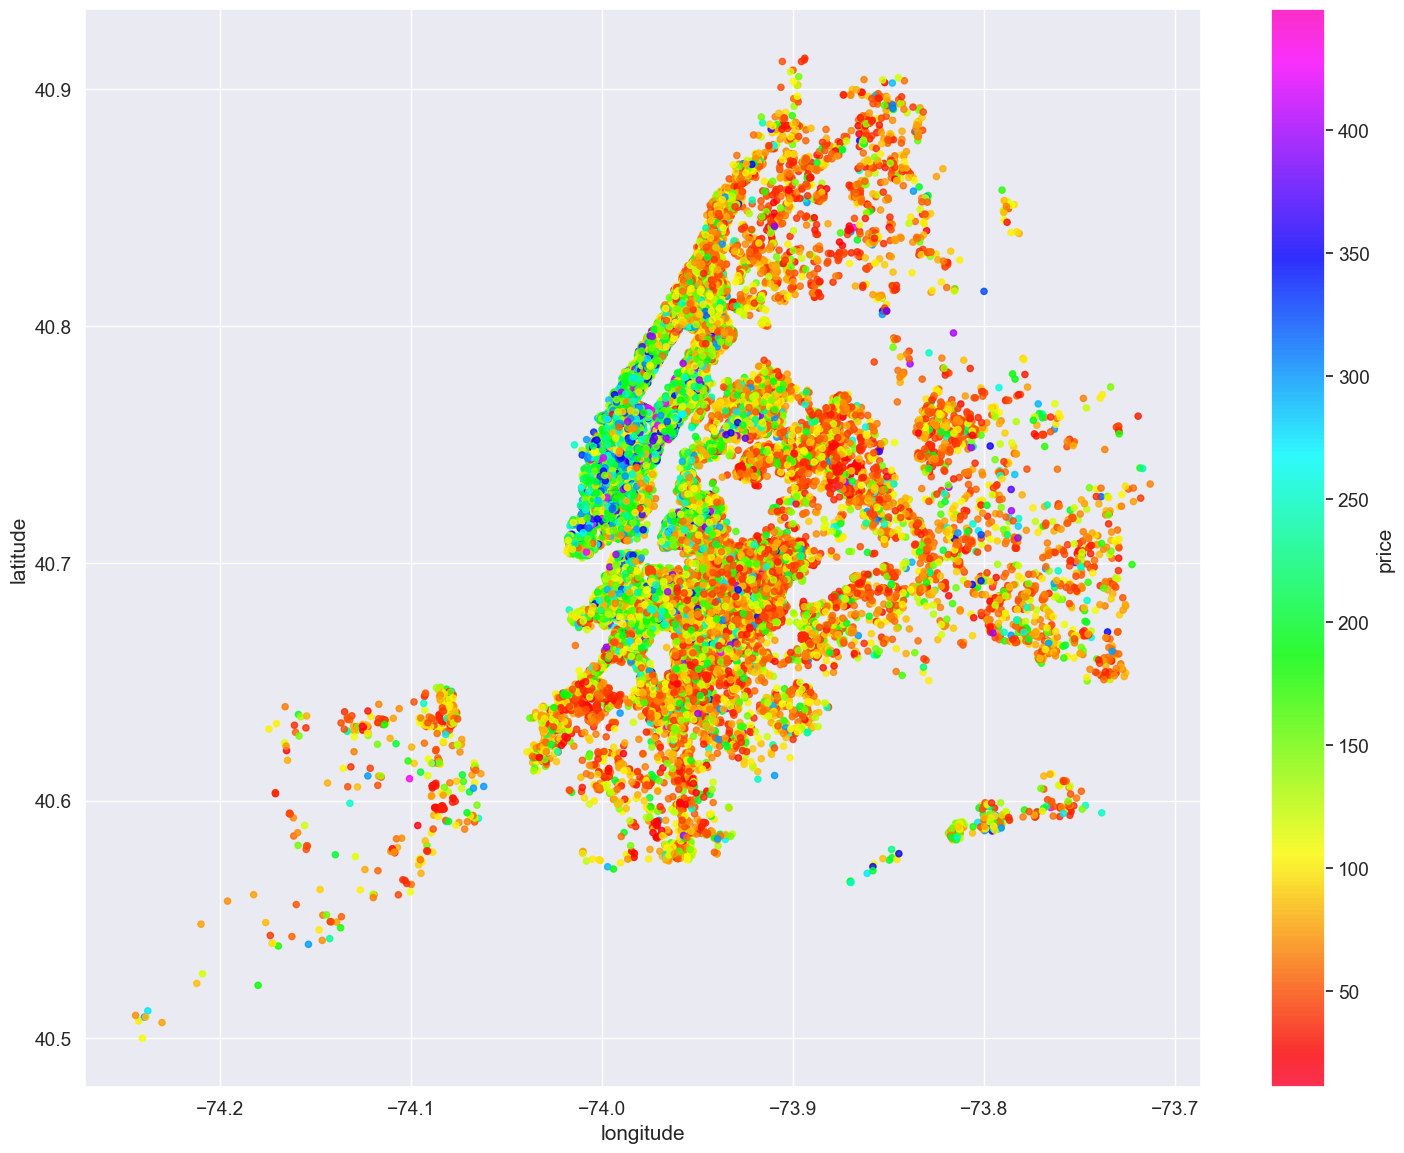

In [63]:
# тут придётся немного подрезать датасет
part_data = data.loc[(data.price < 450) & (data.price > 10)]
part_data.plot(kind='scatter', x='longitude', y='latitude', c='price',
                cmap=plt.get_cmap('gist_rainbow'), colorbar=True, alpha=0.8, figsize=(18,14))

видно, что чем ближе к центру, тем дороже, что логично.
good, посмотрим, где больше концентрация самого влияющего параметра на цену - room_type_Entire home/apt:

Наибольшая концентрация в центре - ожидаемо там больше цена.

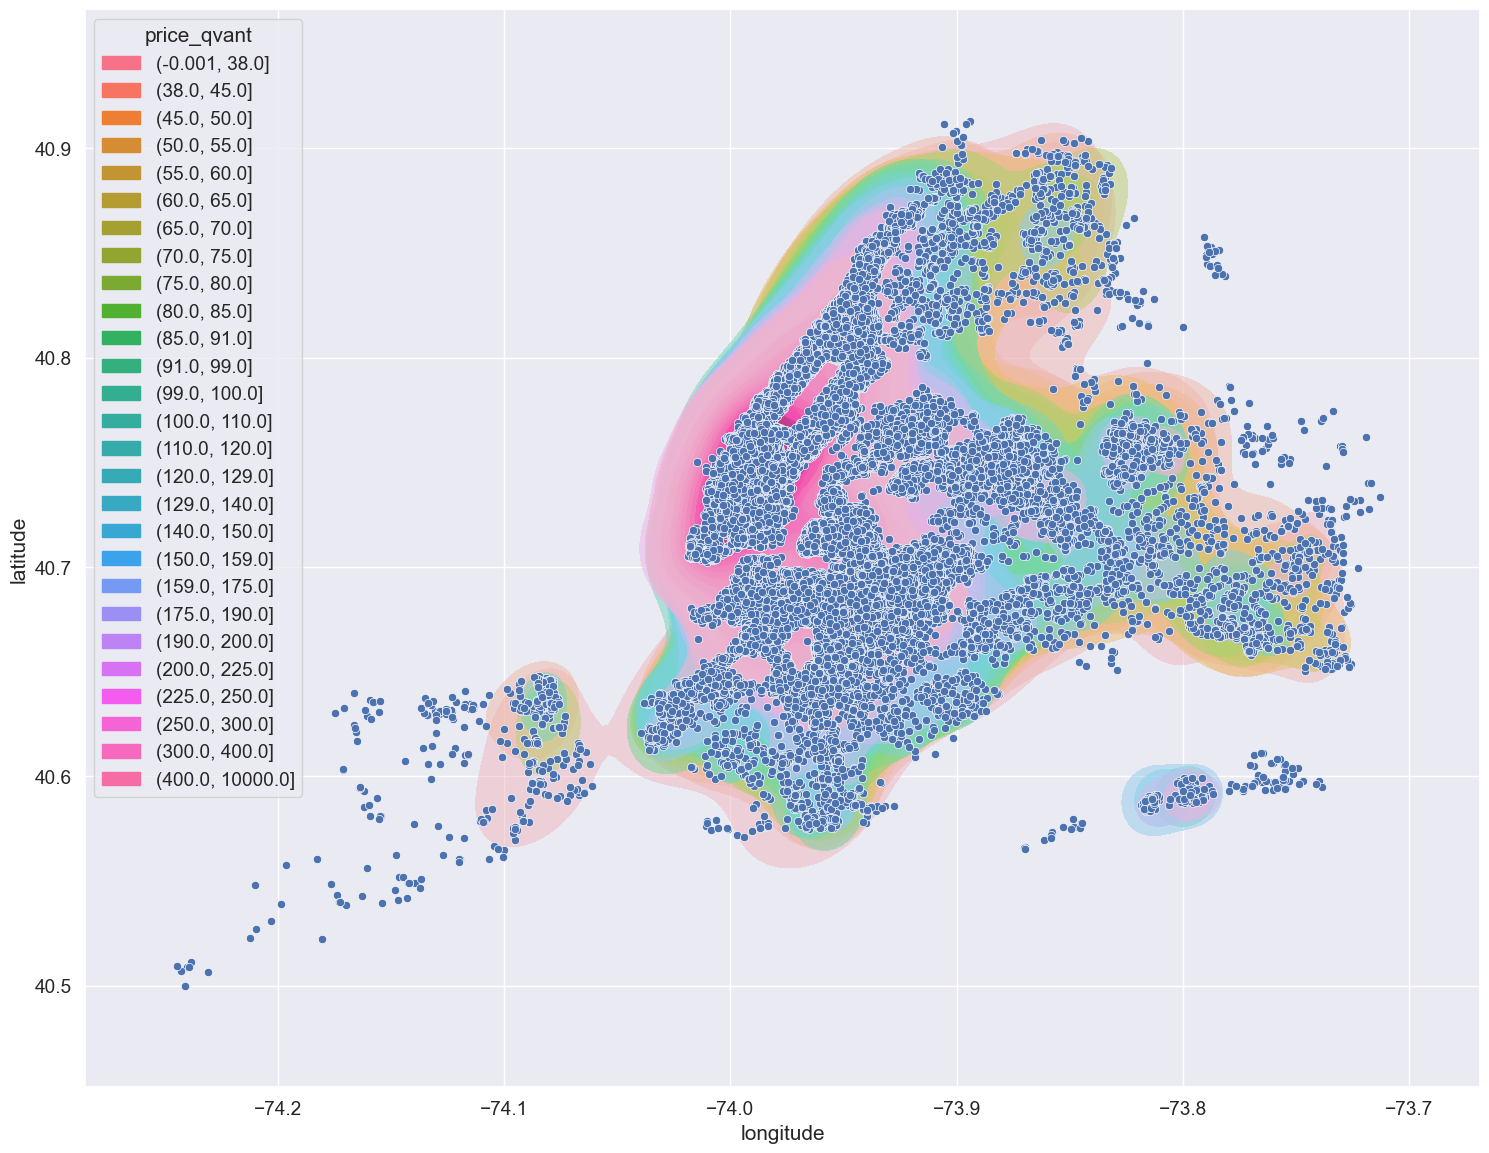

In [66]:
# создадим переменную, которая будет использоваться для разбиения целевой переменной на квантили и посмотрим на карте распределение
qvant = np.array(np.around(np.linspace(0, 1, num=28), 3))
price_bins = data.price.quantile(qvant)

data['price_qvant'] = pd.cut(data['price'], price_bins, right=True, include_lowest=True)

plt.subplots(figsize=(18,14))

sns.kdeplot(x=data["longitude"], y=data["latitude"], hue=data['price_qvant'], cmap=plt.get_cmap('gist_rainbow'), alpha=0.5, fill=True)

sns.scatterplot(x=data.longitude, y=data.latitude)

data = data.drop(['price_qvant'], axis=1)

Тут видны очертания зон с различным уровнем цен.

# попробуем посчитать корелляцию расстояния до центра к цене:

In [67]:
data['big_apple'] = (abs(data['longitude'] + 73.96) + abs(data['latitude'] - 40.78))
data[['price','big_apple']].corr()

,price,big_apple
price,1.000000,-0.103323
big_apple,-0.103323,1.000000


In [68]:
data['euclidian_big_apple'] = np.sqrt((data['longitude'] + 73.96)**2 + (data['latitude'] - 40.78)**2)
data[['price','euclidian_big_apple']].corr()

,price,euclidian_big_apple
price,1.000000,-0.114085
euclidian_big_apple,-0.114085,1.000000


корелляция маленькая, скорее всего это связанно с сильными выбросами цены

In [69]:
part_data = data.loc[(data.price < 850) & (data.price > 10)]
# part_data = data.loc[(data.price < 10100) & (data.price > 1000)]

part_data['euclidian_big_apple'] = np.sqrt((part_data['longitude'] + 73.96)**2 + (part_data['latitude'] - 40.78)**2)
part_data[['price','euclidian_big_apple']].corr()

,price,euclidian_big_apple
price,1.000000,-0.221153
euclidian_big_apple,-0.221153,1.000000


на сильно усечённом ддатасете корелляция вдвое больше, но только для сегмента < 800, а для сегмента от 1000 до 10000 этот параметр влияния не имеет

Как вывод можно отметить, что самое основное на что смотрят модели в данном датасете - это показатель того, что сдают целый дом/квартиру.
Т.к. зависимость практически линейная, то никакой тюнинг не помогает. Для полноты картины нужна дополнительная информация о сдаваемом жилье.

# Lets try Catboost!

In [490]:
! pip install catboost

In [70]:
from catboost import CatBoostRegressor
# Приготовим набор для тренировки и тестирования
X = log_data.drop('LogPrice', axis=1)
Y = log_data['LogPrice']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

In [71]:
itor = [10, 50, 100, 500, 1000]
cat_res = {}
for i in itor[::-1]:
    res = {}
    cat_reg = CatBoostRegressor(random_state=42, iterations=i, task_type="GPU", verbose=False)
    cat_reg.fit(X_train, y_train)
    y_pred_catboost = cat_reg.predict(X_test)
    y_train_pred = cat_reg.predict(X_train)
    print('i=', i)
    print('R2:', round(r2_score(y_test, y_pred_catboost), 3))
    print('MAE:', round(mean_absolute_error(y_test, y_pred_catboost), 3))
    print('RMSE:', round(mean_squared_error(y_test, y_pred_catboost, squared=False), 3))
    res["Test MSE"] = mean_squared_error(y_test, y_pred_catboost)
    res["Train MSE"] = mean_squared_error(y_train, y_train_pred)
    res["Test MAE"] = mean_absolute_error(y_test, y_pred_catboost)
    res["Train MAE"] = mean_absolute_error(y_train, y_train_pred)
    res["Test r2_score"] = r2_score(y_test, y_pred_catboost)
    res["Train r2_score"] = r2_score(y_train, y_train_pred)
    cat_res[type(cat_reg).__name__] = res


cat_df = pd.DataFrame(cat_res, index=['Test MSE', 'Train MSE', 'Test MAE', 'Train MAE', 'Test r2_score',
                                      'Train r2_score'])

i= 1000
R2: 0.613
MAE: 0.307
RMSE: 0.427
i= 500
R2: 0.612
MAE: 0.308
RMSE: 0.428
i= 100
R2: 0.611
MAE: 0.309
RMSE: 0.429
i= 50
R2: 0.606
MAE: 0.311
RMSE: 0.432
i= 10
R2: 0.586
MAE: 0.319
RMSE: 0.442


In [72]:
cat_df

,CatBoostRegressor
Test MSE,0.195533
Train MSE,0.204140
Test MAE,0.319448
Train MAE,0.320650
Test r2_score,0.586285
Train r2_score,0.581798


In [73]:
# сделаем общую таблицу результатво:
merge_df = pd.concat([llre_df, cat_df], axis=1)

In [74]:
merge_df

,LinearRegression,Lasso,Ridge,ElasticNet,CatBoostRegressor
Test MSE,0.238176,0.472669,0.238209,0.465032,0.195533
Train MSE,0.251482,0.488139,0.251490,0.479603,0.204140
Test MAE,0.356742,0.546079,0.356682,0.538770,0.319448
Train MAE,0.361308,0.550710,0.361221,0.542642,0.320650
Test r2_score,0.496060,-0.000089,0.495989,0.016071,0.586285
Train r2_score,0.484815,0.000000,0.484799,0.017486,0.581798


Ожидаемо CatBoost показал себя лучше остальных моделей.
Построим график feature_importance:

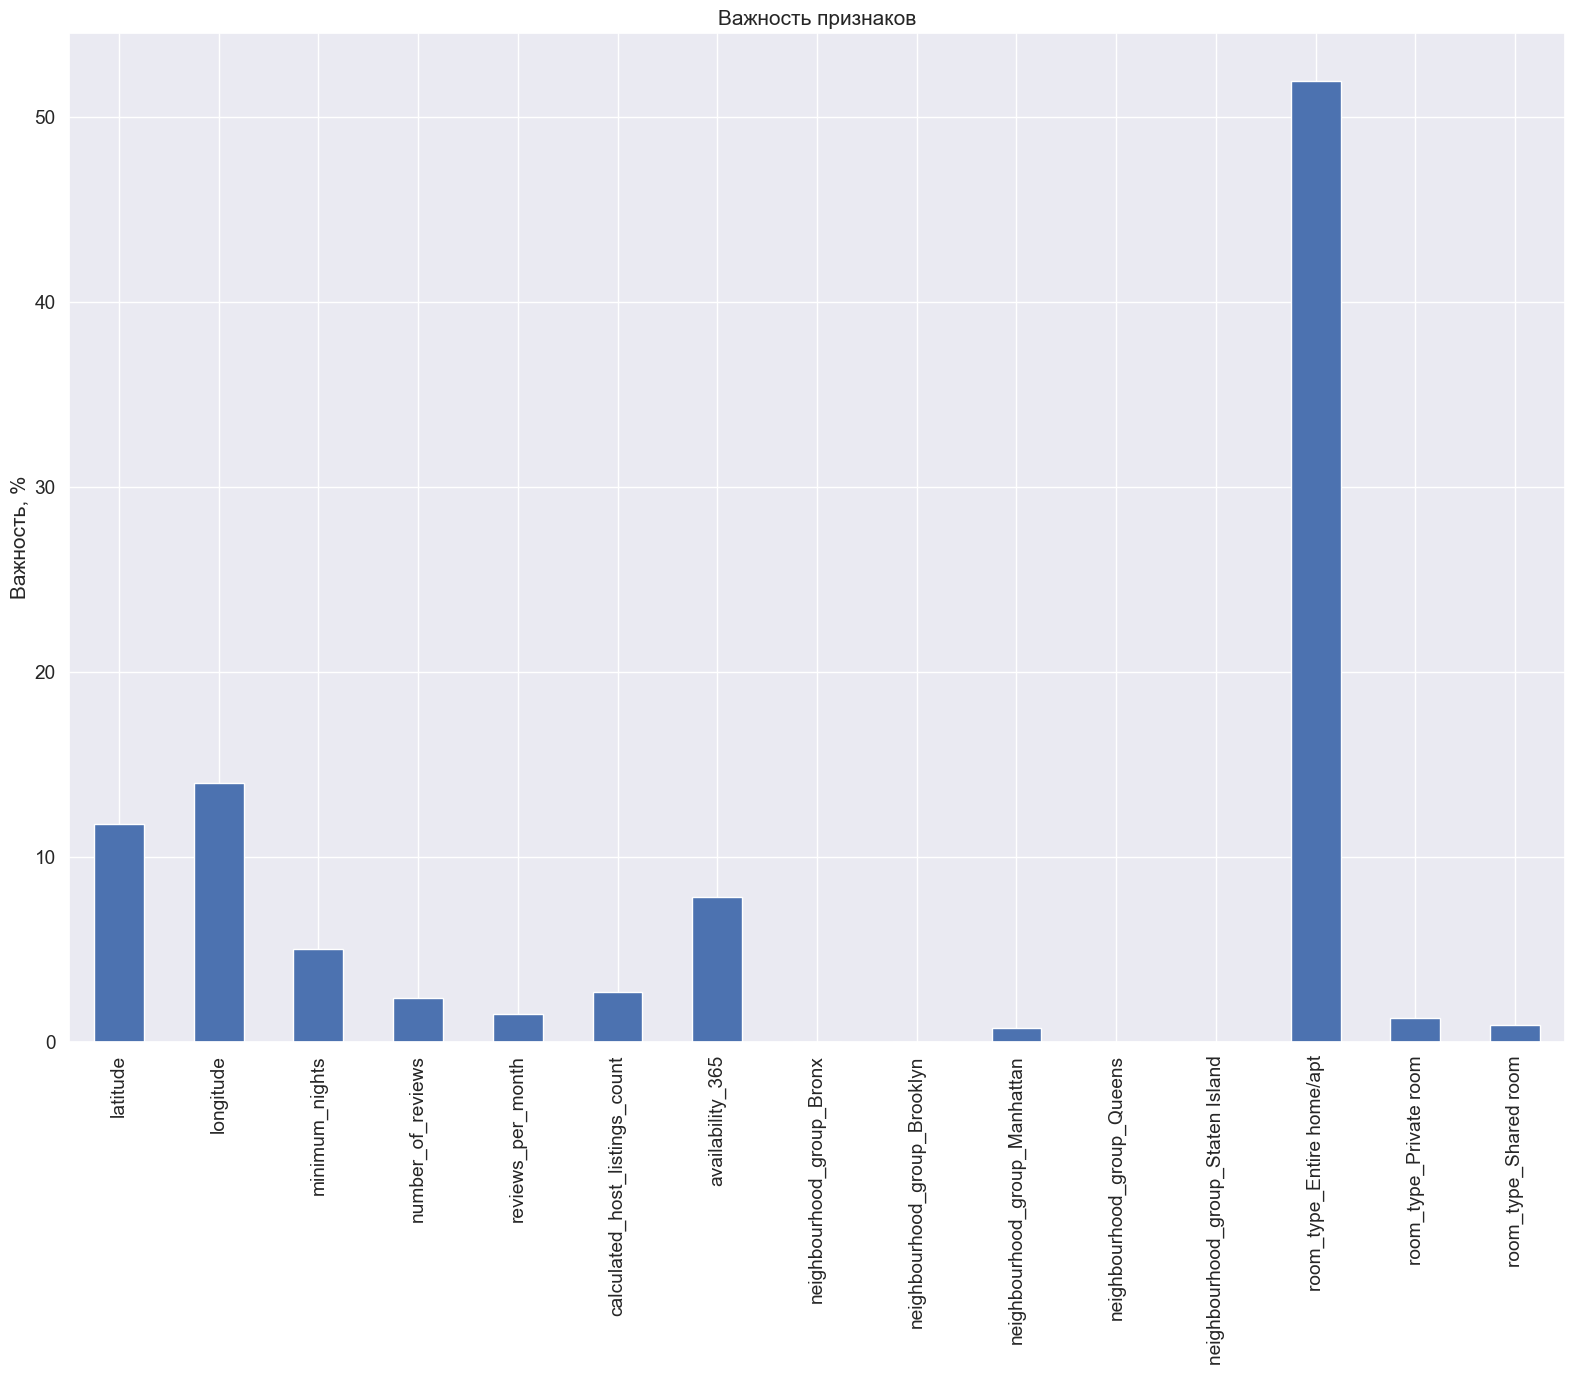

In [75]:
cat_imp = pd.Series(cat_reg.get_feature_importance(),
                         log_data.drop(['LogPrice'], axis=1).columns)
fig, ax = plt.subplots(figsize=(16,14))
cat_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

Снова видим явное преобладание признака room_type_Entire home/apt.